In [1]:
# PyMC for Bayesian Inference
import pymc as pm
import arviz as az
import bambi as bmb
print(f"Running on PyMC v{pm.__version__}")

# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Scikit-learn utilities
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Matplotlib and seaborn for visualizations
import matplotlib.pyplot as plt
%matplotlib inline

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.6.1


In [2]:
df = pd.read_csv('data/HI_Small_Trans_Standardised.csv')
df.head()

,FromAccount,ToAccount,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,Timestamp,AmountPaid,AmountReceived,IsLaundering
0,6530,6530,8,8,12,12,5,2022-09-01 00:20:00,3697.34,3697.34,0
1,358174,176809,109,0,12,12,3,2022-09-01 00:20:00,0.01,0.01,0
2,358476,358476,110,110,12,12,5,2022-09-01 00:00:00,14675.57,14675.57,0
3,74640,74640,10,10,12,12,5,2022-09-01 00:02:00,2806.97,2806.97,0
4,6538,6538,8,8,12,12,5,2022-09-01 00:06:00,36682.97,36682.97,0


In [3]:
# additional feature pre-processing

# Split Timestamp column into MM, DD, HH etc. (Ignore dt columns with constant values)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
# df['Year'] = df['Timestamp'].dt.year
# df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
# df['Second'] = df['Timestamp'].dt.second
df = df.drop(columns=['Timestamp'])

# Benford's law: Add first leading digit from both "Amount Paid" & "Amount Received" columns
def get_first_digit(figure:float) -> int:
    exception_set = ('0','.','e','-')
    for char in str(figure):
        if char not in exception_set:
            return int(char)

# df['LD Amount Paid'] = df['Amount Paid'].astype(str).str[:1].astype(int)
df['LDAmountPaid'] = df.apply(lambda x: get_first_digit(x['AmountPaid']), axis=1)
# df['LD Amount Received'] = df['Amount Received'].astype(str).str[:1].astype(int)
df['LDAmountReceived'] = df.apply(lambda x: get_first_digit(x['AmountReceived']), axis=1)

df.head()

,FromAccount,ToAccount,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,AmountPaid,AmountReceived,IsLaundering,Day,Hour,Minute,LDAmountPaid,LDAmountReceived
0,6530,6530,8,8,12,12,5,3697.34,3697.34,0,1,0,20,3,3
1,358174,176809,109,0,12,12,3,0.01,0.01,0,1,0,20,1,1
2,358476,358476,110,110,12,12,5,14675.57,14675.57,0,1,0,0,1,1
3,74640,74640,10,10,12,12,5,2806.97,2806.97,0,1,0,2,2,2
4,6538,6538,8,8,12,12,5,36682.97,36682.97,0,1,0,6,3,3


<Axes: ylabel='Frequency'>

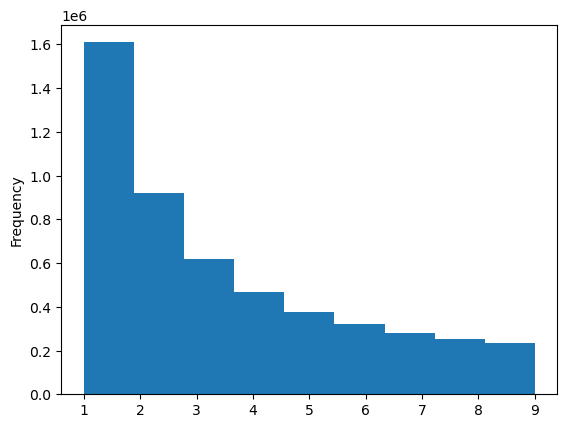

In [4]:
df['LDAmountPaid'].plot.hist(bins=9)

<Axes: ylabel='Frequency'>

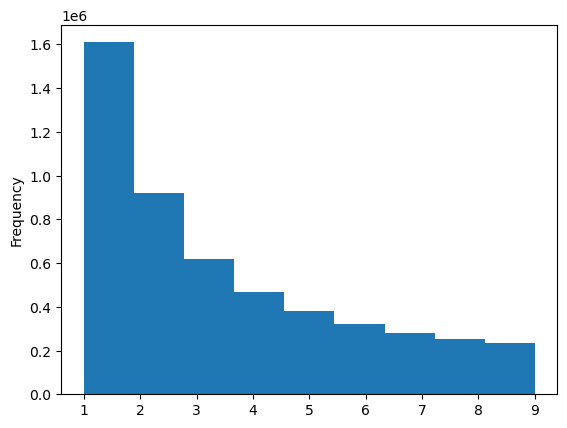

In [5]:
df['LDAmountReceived'].plot.hist(bins=9)

In [6]:
features = df.drop(columns='IsLaundering')
labels = df['IsLaundering']
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [7]:
# undersampling majority class
train_df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)],axis=1)
class_counts = train_df['IsLaundering'].value_counts()
df_majority = train_df[train_df['IsLaundering'] == 0]
df_minority = train_df[train_df['IsLaundering'] == 1]
df_majority_downsampled = resample(df_majority, replace=False, n_samples=class_counts[1])
df_balanced = pd.concat([df_majority_downsampled, df_minority])
X_train, y_train = df_balanced.iloc[:, :-1], df_balanced.iloc[:, [-1]]

<Axes: ylabel='Frequency'>

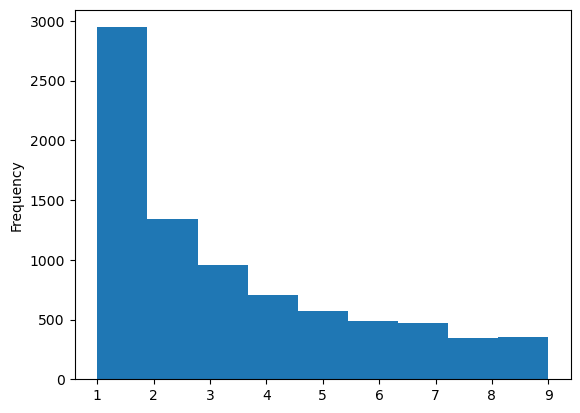

In [8]:
df_balanced['LDAmountReceived'].plot.hist(bins=9)

<Axes: ylabel='Frequency'>

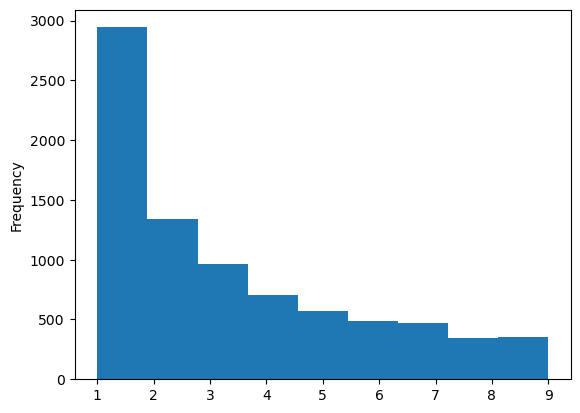

In [9]:
df_balanced['LDAmountPaid'].plot.hist(bins=9)

### Bayesian Logistic Regression

In [10]:
# Build up a formula
formula = [' %s + ' % variable for variable in X_train.columns]
formula.insert(0, 'y ~ ')
formula = ' '.join(''.join(formula).split(' ')[:-2])
formula

'y ~  FromAccount +  ToAccount +  FromBank +  ToBank +  ReceivingCurrency +  PaymentCurrency +  PaymentFormat +  AmountPaid +  AmountReceived +  Day +  Hour +  Minute +  LDAmountPaid +  LDAmountReceived'

In [11]:
# Create version of the training data with labels
X_with_labels = X_train.copy()
X_with_labels['y'] = y_train

In [12]:
X_with_labels.describe()

,FromAccount,ToAccount,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,AmountPaid,AmountReceived,Day,Hour,Minute,LDAmountPaid,LDAmountReceived,y
count,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8.180000e+03,8.180000e+03,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000
mean,241245.386308,208011.408313,1894.199022,2372.775672,8.369560,8.382029,1.732518,2.557397e+07,2.557575e+07,5.737408,11.134108,28.694010,3.219927,3.218093,0.500000
std,163351.232355,143409.924185,3182.152693,2845.184271,4.028839,4.030437,1.857589,1.233772e+09,1.233771e+09,3.378332,6.844007,17.331831,2.445727,2.444516,0.500031
min,55.000000,297.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e-06,1.000000e-06,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,108547.500000,92899.000000,33.750000,90.000000,4.000000,4.000000,0.000000,6.404275e+02,6.402850e+02,2.000000,5.000000,13.000000,1.000000,1.000000,0.000000
50%,206221.000000,184908.000000,620.000000,787.000000,10.000000,10.000000,1.000000,4.298875e+03,4.298875e+03,6.000000,11.000000,28.000000,2.000000,2.000000,0.500000
75%,360092.750000,286121.750000,996.250000,6045.250000,12.000000,12.000000,3.000000,1.702935e+04,1.704735e+04,8.000000,17.000000,44.000000,5.000000,5.000000,1.000000
max,515053.000000,515072.000000,29922.000000,29922.000000,14.000000,14.000000,6.000000,8.485314e+10,8.485314e+10,18.000000,23.000000,59.000000,9.000000,9.000000,1.000000


In [13]:
# Building of Bayesian Logistic Regression model
model = bmb.Model(formula, X_with_labels, family="bernoulli")
model.build()

Sampling: [AmountPaid, AmountReceived, Day, FromAccount, FromBank, Hour, Intercept, LDAmountPaid, LDAmountReceived, Minute, PaymentCurrency, PaymentFormat, ReceivingCurrency, ToAccount, ToBank]


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'FromAccount'}>,
        <Axes: title={'center': 'ToAccount'}>],
       [<Axes: title={'center': 'FromBank'}>,
        <Axes: title={'center': 'ToBank'}>,
        <Axes: title={'center': 'ReceivingCurrency'}>],
       [<Axes: title={'center': 'PaymentCurrency'}>,
        <Axes: title={'center': 'PaymentFormat'}>,
        <Axes: title={'center': 'AmountPaid'}>],
       [<Axes: title={'center': 'AmountReceived'}>,
        <Axes: title={'center': 'Day'}>,
        <Axes: title={'center': 'Hour'}>],
       [<Axes: title={'center': 'Minute'}>,
        <Axes: title={'center': 'LDAmountPaid'}>,
        <Axes: title={'center': 'LDAmountReceived'}>]], dtype=object)

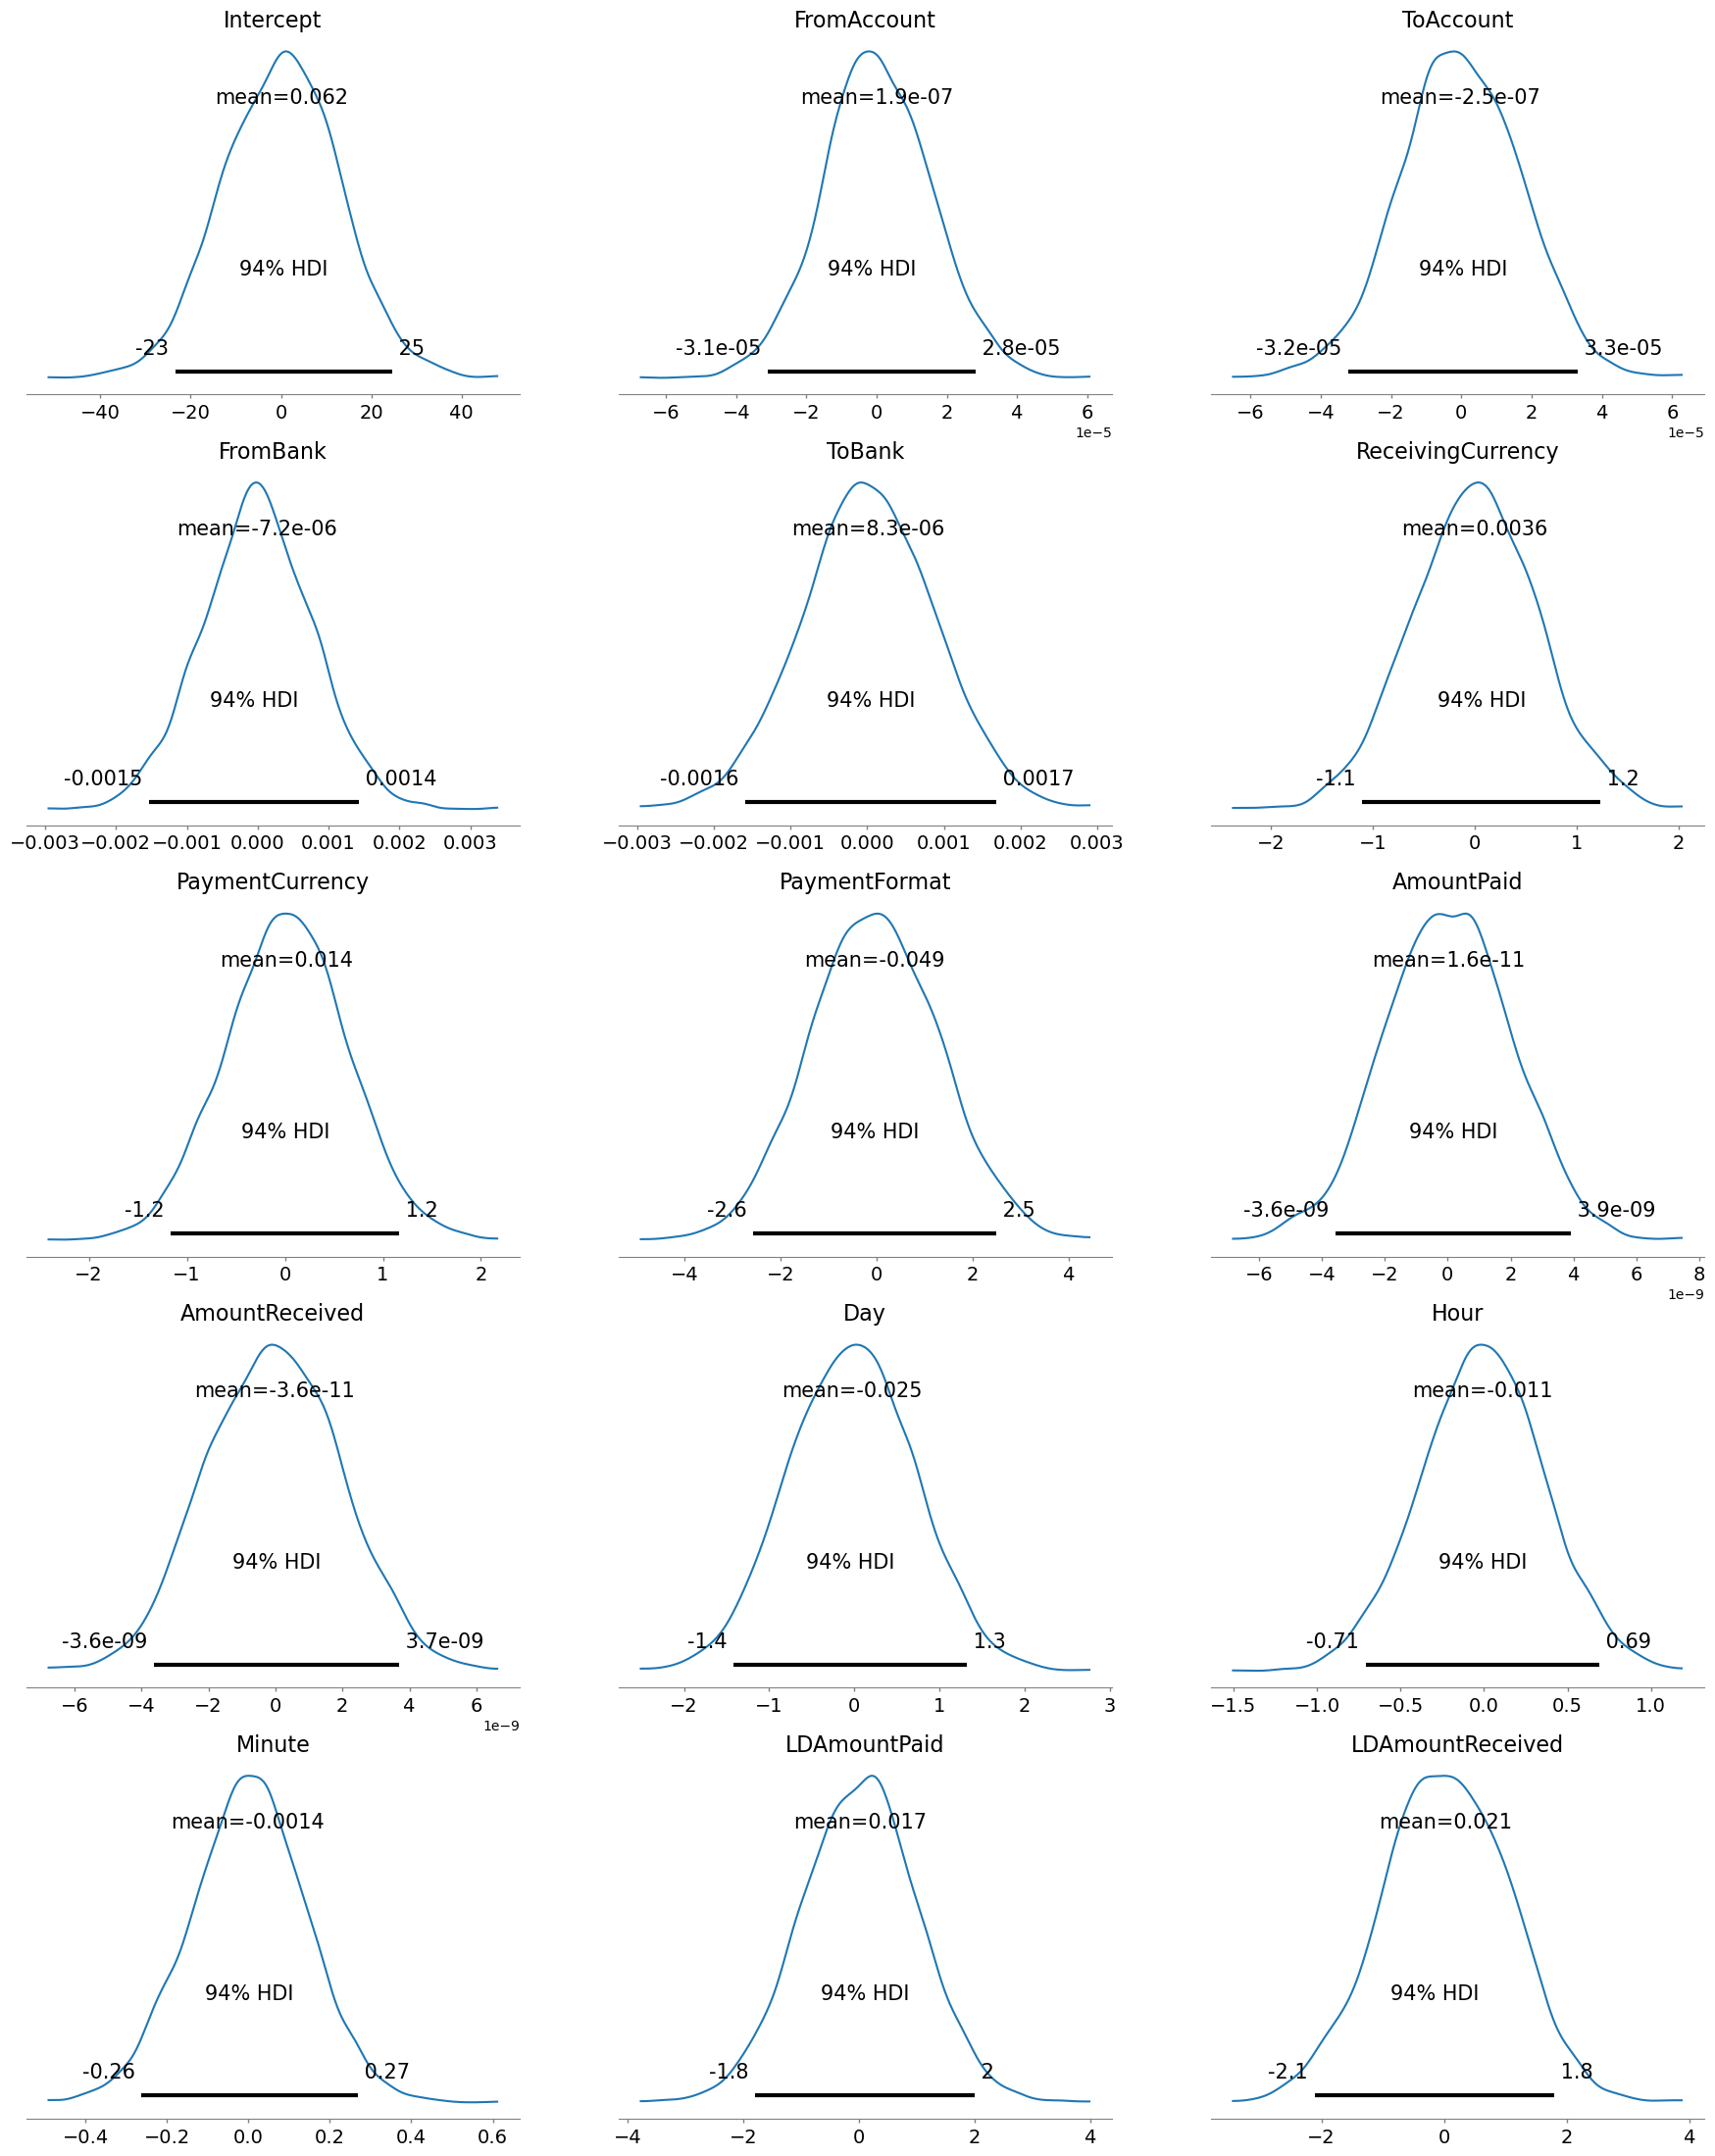

In [14]:
# Plot marginal priors of the model
model.plot_priors()

In [15]:
# fit the model
results = model.fit(draws=1000, chains=2)

Modeling the probability that y==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, FromAccount, ToAccount, FromBank, ToBank, ReceivingCurrency, PaymentCurrency, PaymentFormat, AmountPaid, AmountReceived, Day, Hour, Minute, LDAmountPaid, LDAmountReceived]
